This file is part of F1StrategyAssistent.

F1StrategyAssistent is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

F1StrategyAssistent is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

F1StrategyAssistent is unofficial and is not associated in any way with the Formula 1 companies. F1, FORMULA ONE, FORMULA 1, FIA FORMULA ONE WORLD CHAMPIONSHIP, GRAND PRIX and related marks are trade marks of Formula One Licensing B.V.

In [3]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import fastf1 as ff1
import fastf1.plotting

In [4]:
pit_stop_cost={
    'Canada': 0.18,
    'United Kingdon': 0.20,
    'Italy': 0.23,
    'Bahrein': 0.23,
    'Saudi Arabia': 0.2
}

pit_stop_cost_sc={
    'Canada':0.9,
    'United Kingdon':0.9,
    'Italy': 0.15,
    'Bahrein': 16,
    'Saudi Arabia': 0.11

}

In [5]:
def gpData1(year, country, session):

    session = ff1.get_session(year, country, session)
    session.load()
    laps = session.laps
    laps.sort_values(by=['LapNumber', 'Position'], inplace=True)
    laps.reset_index(drop=True, inplace=True)
    weather = laps.get_weather_data()
    race = pd.DataFrame({
        'LapNumber': laps['LapNumber'].values,
        'Position': laps['Position'].values,
        'Compound': laps['Compound'].values,
        'TyreLife': laps['TyreLife'].values,
        'TrackStatus': laps['TrackStatus'].map(lambda x: 1 if x == 4 else (2 if x == 6 else 0)),
        'TrackTemp': weather['TrackTemp'].values,
        'Rainfall': weather['Rainfall'].values.astype(int)
    })
    race['RoundNumber'] = session.event.RoundNumber

    laps.sort_values(by=['Driver', 'LapNumber'], inplace=True)
    
   # Define the condition when a car is making a pit stop
    pit_stop_condition = (
    (laps['PitInTime'].notna()) &
    (laps['TyreLife'] >= laps['TyreLife'].shift(-1)) &
    (laps['PitOutTime'].shift(-1).notna())
    )

    # Create a target series for pit stop (1 for pit, 0 for no pit)
    pitting = pd.Series(np.where(pit_stop_condition, 1, 0))
    pitting.index = laps.index
    pitting.sort_index(inplace=True)

    return race, pitting

In [7]:
saudi2023, saudi2023_target = gpData1(2023, 'Saudi Arabia', 'r')
saudi2024, saudi2024_target = gpData1(2024, 'Saudi Arabia', 'r')

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


KeyboardInterrupt: 

In [8]:
# Combine lap data from the 2 races.
lapData = pd.concat([saudi2023, saudi2024], ignore_index=True)
target = pd.concat([saudi2023_target, saudi2024_target], ignore_index=True)

In [9]:
# make bools into ints
lapData['Rainfall'] = lapData['Rainfall'].astype(int)

# encode compound types
lapData['Compound'] = lapData['Compound'].astype('category').cat.codes

# make column category types
lapData['Position'] = lapData['Position'].astype('category')
lapData['Compound'] = lapData['Compound'].astype('category')
lapData['Rainfall'] = lapData['Rainfall'].astype('category')
lapData['RoundNumber'] = lapData['RoundNumber'].astype('category')
lapData.dtypes

LapNumber       float64
Position       category
Compound       category
TyreLife        float64
TrackStatus       int64
TrackTemp       float64
Rainfall       category
RoundNumber    category
dtype: object

In [8]:
def gpData(year, country, session):
    """
    Parameters:
        year (int): The year of the race (e.g., 2023, 2024).
        country (str): The country where the race is held (e.g., 'Saudi Arabia').
        session (str): The session of the race (e.g., 'r' for race, 'q' for qualifying).

    Returns:
        race (DataFrame): A DataFrame containing lap-level data and derived features.
        pitting (Series): A series indicating whether a pit stop occurred (1 for pit, 0 for no pit).
    """

    # Load the specified session using the FastF1 API
    session = ff1.get_session(year, country, session)
    session.load()

    # Extract lap data and sort by lap number and position
    laps = session.laps
    laps.sort_values(by=['LapNumber', 'Position'], inplace=True)
    laps.reset_index(drop=True, inplace=True)

    # Get weather data for the session
    weather = laps.get_weather_data()

    # Create the race DataFrame with relevant lap-level data
    race = pd.DataFrame({
        'LapNumber': laps['LapNumber'].values,
        'Position': laps['Position'].values,
        'Compound': laps['Compound'].values,
        'TyreLife': laps['TyreLife'].values,
        'TrackStatus': laps['TrackStatus'].map(lambda x: 1 if x == 4 else (2 if x == 6 else 0)),
        'TrackTemp': weather['TrackTemp'].values,
        'Rainfall': weather['Rainfall'].values.astype(int)
    })


    # Calculate the delta time between consecutive laps for each driver
    lap_time_delta = pd.Series()

    for i, driver in laps.groupby('Driver'):
        delta =[]
        delta = driver['LapTime'].dt.total_seconds().diff()
        delta.fillna(0, inplace=True)
        lap_time_delta = pd.concat([lap_time_delta, delta])

    race['DeltaTime'] = lap_time_delta


    # Calculate average distance to the driver ahead over a lap in seconds
    gap = []
    for i, l in laps.iterlaps():
        dist = l.get_telemetry().DistanceToDriverAhead
        speed = l.get_telemetry().Speed*3.6

        gap.append((dist/speed).mean())

    race['GapAhead'] = gap
    race['GapAhead'].replace(np.inf,np.nan, inplace=True)
    race['GapAhead'].fillna(0, inplace=True)

    
    # Add country of the race
    race['Country'] = session.event.Country

    
    # Calculate the number of positions that would be lost if the driver pitted in that lap
    lost_pos = []

    for i,group in race.groupby('LapNumber'):
        k = 0
        for j in group.index:
            if group.loc[j,'TrackStatus'] == 0:
                pit_loss = 0.2
                
            else :
                pit_loss = 0.11
            counter = 1
            loss = 0
            while (loss < pit_loss) & ((k+counter) < group.index.size):
                loss += group.loc[j+counter,'GapAhead']
                counter += 1

            lost_pos.append(counter)
            k += 1

    race['PosToLose'] = lost_pos

    
    race['TotalLaps'] = laps['LapNumber'].max()
    race['RemainingLaps'] = race['TotalLaps'] - race['LapNumber']

    
    laps.sort_values(by=['Driver', 'LapNumber'], inplace=True)
    
   # Define the condition when a car is making a pit stop
    pit_stop_condition = (
    (laps['PitInTime'].notna()) &
    (laps['TyreLife'] >= laps['TyreLife'].shift(-1)) &
    (laps['PitOutTime'].shift(-1).notna())
    )

    # Create a target series for pit stop (1 for pit, 0 for no pit)
    pitting = pd.Series(np.where(pit_stop_condition, 1, 0))
    pitting.index = laps.index
    pitting.sort_index(inplace=True)

    return race, pitting

In [9]:
saudi23, saudi23_target = gpData(2023, 'Saudi Arabia', 'r')
saudi24, saudi24_target = gpData(2024, 'Saudi Arabia', 'r')

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 11 completed the race distance 00:00.035000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['11', '1', '14', '63', '44', '55', '16', '31', '10', '20', '

In [12]:
# Combine lap data from the 2 races.
lapData = pd.concat([saudi23, saudi24], ignore_index=True)
target = pd.concat([saudi23_target, saudi24_target], ignore_index=True)

In [13]:
# Drop rows with missing "Position" values.
rows_to_drop = lapData[lapData["Position"].isna()].index
lapData = lapData.drop(rows_to_drop)
target = target.drop(rows_to_drop)

In [14]:
# Encode compound types
lapData['Compound'] = lapData['Compound'].map(compounds)

# Convert relevant columns into categorical data types.
lapData['Position'] = lapData['Position'].astype('category')#.cat.codes
lapData['Compound'] = lapData['Compound'].astype('category')
lapData['Rainfall'] = lapData['Rainfall'].astype('category')#.cat.codes

lapData = lapData.drop(columns=['Country'])

In [146]:
lapData_copy = lapData.copy()

In [57]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# lapData[lapData] = scaler.fit_transform(lapData[lapData])

In [177]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Initialize model
model = RandomForestClassifier(random_state=42, 
                        max_depth = 5, 
                        min_samples_leaf = 10, 
                        n_estimators = 50, 
                        class_weight= {0: 1, 1: 10})

# Perform 5-fold cross-validation
scores = cross_val_score(model, lapData, target, cv=5)

# Print the average score
print("Average R² score:", scores.mean())

Average R² score: 0.980468657947449


In [182]:
model = RandomForestClassifier(
            random_state=42, 
            max_depth = 5, 
            min_samples_leaf = 5, 
            n_estimators = 50, 
            class_weight= {0: 1, 1: 10})

In [ ]:
model = RandomForestClassifier(
            random_state=42,
            max_depth = 5, 
            min_samples_split = 2, 
            n_estimators = 50, 
            class_weight= {0: 1, 1: 5})

In [100]:
model = RandomForestClassifier(
            random_state=42, 
            max_depth = 5, 
            min_samples_split = 2, 
            n_estimators = 50, 
            class_weight= 'balanced')

In [208]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# model = RandomForestClassifier(
#             random_state=42, 
#             max_depth = 5, 
#             min_samples_split = 2, 
#             n_estimators = 50, 
#             class_weight= {0: 1, 1: 5})
            
# Split data into training and test sets (80/20 split).
lapData_train, lapData_test, target_train, target_test = train_test_split(lapData, target, test_size=0.2, random_state=42)

# Fit model
model.fit(lapData_train, target_train)

# Evaluate the model
predictions = model.predict(lapData_test)


In [209]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
# Calculate precision, recall, and F1 score for binary classification
precision = precision_score(target_test, predictions)
recall = recall_score(target_test, predictions)
f1 = f1_score(target_test, predictions)

# Print classification report for a more detailed overview
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Classification report gives you precision, recall, F1 score for each class
print("\nClassification Report:\n", classification_report(target_test, predictions))


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(target_test, predictions)
cm

Precision: 0.7142857142857143
Recall: 0.625
F1 Score: 0.6666666666666666

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       361
           1       0.71      0.62      0.67         8

    accuracy                           0.99       369
   macro avg       0.85      0.81      0.83       369
weighted avg       0.99      0.99      0.99       369



array([[359,   2],
       [  3,   5]])

ROC AUC Score: 0.9861495844875346


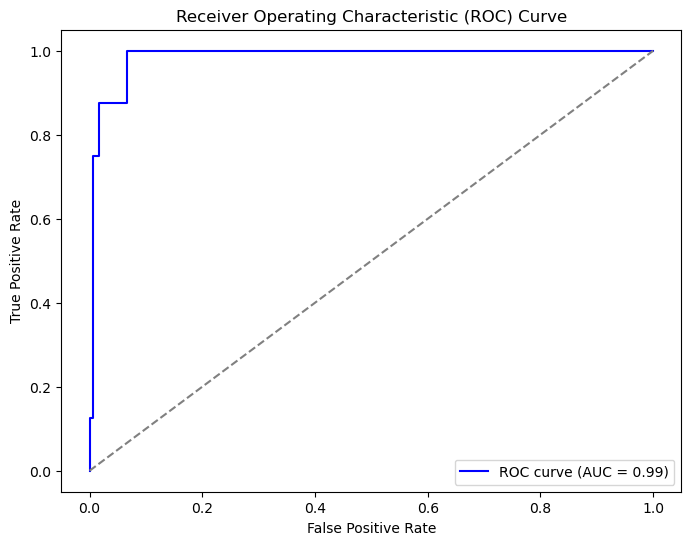

In [173]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
y_prob = model.predict_proba(lapData_test)[:, 1]  # Get probabilities for class 1

# Calculate ROC AUC
roc_auc = roc_auc_score(target_test, y_prob)
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(target_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [207]:
from xgboost import XGBClassifier
model = XGBClassifier(
            objective='binary:logistic',
            enable_categorical=True,
            scale_pos_weight=10,  
            max_depth=4,          
            learning_rate=0.1,    
            subsample=0.7,        
            eval_metric='logloss',
            n_estimators=200
        )

# model.fit(lapData_train, target_train)

In [ ]:
model = XGBClassifier(
            objective='binary:logistic',
            enable_categorical=True,
            eval_metric='logloss',
            n_estimators=100,
            random_state=42
        )

# model.fit(lapData_train, target_train)

In [ ]:
model = XGBClassifier(
            objective='binary:logistic',
            enable_categorical=True,
            eval_metric='logloss',
            max_depth=5,           
            subsample=0.8,         
            colsample_bytree=0.8,  
            reg_alpha=0.1,         
            reg_lambda=0.1,        
            scale_pos_weight=5,
            n_estimators=200
        )


In [ ]:
model = XGBClassifier(
            objective='binary:logistic',
            enable_categorical=True,
            eval_metric='logloss',
            scale_pos_weight=10,    
            max_depth=4,           
            learning_rate=0.1,     
            min_child_weight=3,    
            n_estimators=150
        )

In [ ]:
importances = model.feature_importances_

pd.concat([pd.Series(lapData.columns),pd.Series(importances)], axis=1).sort_values(by=1, ascending=False)

In [23]:
saudi25, saudi25_target = gpData(2025, 'Saudi Arabia', 'r')

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '1', '16', '4', '63', '12', '44', '55', '23', '6', '14', '30', '87', '31', '27', '18', '7', '5', '22', '10']
/var/folders/d_/7s822lfj1tjgdlqm3b8yj60w0000gn/T/ipykerne

In [24]:
copy = saudi25.copy()

In [ ]:
# Drop rows with missing "Position" values.
rows_to_drop = saudi25[saudi25["Position"].isna()].index
saudi25 = saudi25.drop(rows_to_drop)
saudi25_target = saudi25_target.drop(rows_to_drop)

In [ ]:
compounds = { 
    "SOFT": 0,
    "MEDIUM": 1,
    "HARD": 2,
    "INTERMEDIATE": 3,
    "WET": 4
}

In [169]:
# Encode compound types
saudi25['Compound'] = saudi25['Compound'].map(compounds)

# Convert relevant columns into categorical data types.
saudi25['Position'] = saudi25['Position'].astype('category')
saudi25['Compound'] = saudi25['Compound'].astype('category')
saudi25['Rainfall'] = saudi25['Rainfall'].astype('category')

saudi25 = saudi25.drop(columns=['Country'])


In [210]:
predictions = model.predict(saudi25)

In [211]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
# Calculate precision, recall, and F1 score for binary classification

precision = precision_score(saudi25_target, predictions)
recall = recall_score(saudi25_target, predictions)
f1 = f1_score(saudi25_target, predictions)

# Print classification report for a more detailed overview

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Classification report gives you precision, recall, F1 score for each class
print("\nClassification Report:\n", classification_report(saudi25_target, predictions))


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(saudi25_target, predictions)
print("Confusion Matrix:", cm)

Precision: 0.7142857142857143
Recall: 0.7894736842105263
F1 Score: 0.75

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.71      0.79      0.75        19

    accuracy                           0.99       897
   macro avg       0.85      0.89      0.87       897
weighted avg       0.99      0.99      0.99       897

Confusion Matrix: [[872   6]
 [  4  15]]


In [176]:
# For XGBoost (use predicted probabilities, not hard 0/1)
y_pred_proba = model.predict_proba(saudi25)[:, 1]  # Probabilities for class 1
y_pred_new = (y_pred_proba > 0.3).astype(int)    # Lower threshold from 0.5 to 0.3
print(classification_report(saudi25_target, y_pred_new))
cm = confusion_matrix(saudi25_target, y_pred_new)
print("Confusion Matrix:", cm)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.68      0.79      0.73        19

    accuracy                           0.99       897
   macro avg       0.84      0.89      0.86       897
weighted avg       0.99      0.99      0.99       897

Confusion Matrix: [[871   7]
 [  4  15]]
